In [ ]:
import random
import torch
from torch import nn, optim
import math
from IPython import display
import torch.nn.functional as F

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# prepare the sampled ellipse points based on input axes length and noise
# output Y[2][N]
def sampleNoisedEllipsePts(samplesNo, xAxislen , yAxislen, noiseStd = 0.05):
  EllipseAxis = torch.tensor([xAxislen,yAxislen], requires_grad = False)
  #uniform distribution on[0,2*pi]
  theta =torch.rand([samplesNo])*2*math.pi
 # print("theta=" ,theta,'\n')
  #normal distribution for the noise 
  noise = torch.empty([samplesNo])
  noise.normal_(mean =0 ,std = noiseStd)
 # print("noise=",noise,'\n')
  #create the 'noised' ellipse points data 
  Y1 = torch.cat((torch.cos(theta)*EllipseAxis[0]+noise,torch.sin(theta)*EllipseAxis[1]+noise ), 0)
  ptsDim = (2,int(Y1.size(0)/2))
  ellipsePts = torch.reshape(Y1,ptsDim)
 # print ("ellipse pts =", ellipsePts,'  shape = ' ,ellipsePts.shape,'\n')
  return ellipsePts

In [ ]:
# The expected input ellipsePts are given bt the tensor - torch.Size([2, :])
def plot_2Dpts(ellipsePts, color_='tab:red'): 
  plt.scatter(ellipsePts.numpy()[0,:],ellipsePts.numpy()[1,:],color = color_) 
  plt.grid(True, linestyle='-.')
  plt.axis('square')
  plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * 3)

 

In [ ]:
# plot analytic ellipse , with given axis
def plot_Ellipse(xAxislen, yAxisLen, color_='tab:red', samples =100):
   an = np.linspace(0, 2 * np.pi, samples)
   plt.plot(xAxislen * np.cos(an), yAxisLen * np.sin(an),  color_)

In [ ]:
#from torch.autograd.grad_mode import no_grad
# returns the sampled ellipse points corresponding to the (latent)Z -values, that is : A[12][2] = [[cos(theta0), sin(theta0)],[ , ],[ , ],...] 
latentSize = 24
def predicted_latent():
  Z = np.arange(0,2*math.pi,2*math.pi/latentSize)
  #print('latent : Z=',Z,'\n')
  AnalyticEllPts = [(np.cos(i), np.sin(i)) for i in Z]
  #print("AnalyticEllPts=",AnalyticEllPts,'\n')
  A = torch.tensor(AnalyticEllPts,requires_grad=False)
  #print('latent=', A) 

  return A

In [ ]:
# the weights are the ellipse axes lengths W=(w1,w2)
# the NN is the trivial one 
class EllipseAxes(nn.Module):
  def __init__(self, Wx,Wy):
    super().__init__()
    #print('eee')
    self.weights = nn.Parameter(torch.tensor([Wx,Wy]))
  

  def forward(self,dum):
    #print('rrr')
    return self.weights 


In [ ]:
#initialize model , loss and optimizer
Wx= 1.0
Wy =1.25
model = EllipseAxes(Wx,Wy)
loss = nn.MSELoss(reduction = 'sum')
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum =0.5)

dum=torch.tensor([0.,0.], requires_grad=False)

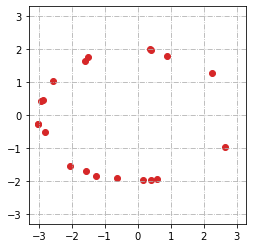

In [ ]:
# create the input Data Yi , and the initial Guess for W
samplesNo = 20
xAxislen = 3.0
yAxislen = 2.0
Y = sampleNoisedEllipsePts(samplesNo, xAxislen , yAxislen, noiseStd = 0.05)
#print('Y=',Y.shape,'\n' ,Y)
plot_2Dpts(Y)



In [ ]:
def F_beta(W,Yi):
  beta = 10
  Z = predicted_latent()
 
  #print('W=',W)
  Y_pred=Z.mul(W)
 # print('Y_pred=',Y_pred)
  Yi_ = Yi.unsqueeze(0)    
  Yi_stretched = Yi_.expand(Y_pred.size(0), -1 )   
  #print('Yi_stretched=', Yi_stretched)
  E = Yi_stretched-Y_pred
  #print('E',E)
  E1= E.mul(E)
  #print('E1',E1) 
  E2 = torch.sum(E1, dim=1)
  #print('E2',E2) 
  err = (-1./beta)*torch.logsumexp(-beta*E2,dim = 0)
  return err


In [ ]:
def F_inf(W,Yi):

  Z = predicted_latent() 
  #print('W=',W)
  Y_pred=Z.mul(W)
  # print('Y_pred=',Y_pred)
  Yi_ = Yi.unsqueeze(0)    
  Yi_stretched = Yi_.expand(Y_pred.size(0), -1 )   
  #print('Yi_stretched=', Yi_stretched)
  E = Yi_stretched-Y_pred
  #print('E',E)
  E1= E.mul(E)
  #print('E1',E1) 
  E2 = torch.sum(E1, dim=1)
  #print('E2',E2) 
  E3 = torch.min(E2)
  err=E3
  return err

  

In [ ]:
# training : unconditional case
W = model(dum)
Yt = torch.transpose(Y,0,1)
for i in range (Yt.size(0)):
  Yi =  Yt[i,:]
  print('\n', i+1,':')
  print('Yi=',Yi)
  # err = F_beta(W,Yi)   
  err =  F_inf(W,Yi) 
  optimizer.zero_grad()
  print('err=', err)
  err.backward()
  print('weights [d/dWx , d/dWy] gradients', W.grad)
  #weightslist = list(model.parameters())
  #print(weightslist)
  #print (weightslist[0].grad)
  optimizer.step()
  weightslist1 = list(model.parameters())
  print('weights = ellipse axes =', weightslist1)
 


 1 :
Yi= tensor([-2.8108, -0.5190])
err= tensor(3.4418, dtype=torch.float64, grad_fn=<MinBackward1>)
weights [d/dWx , d/dWy] gradients tensor([-3.5640, -0.1012])
weights = ellipse axes = [Parameter containing:
tensor([1.3564, 1.2601], requires_grad=True)]

 2 :
Yi= tensor([0.9038, 1.7954])
err= tensor(0.5466, dtype=torch.float64, grad_fn=<MinBackward1>)
weights [d/dWx , d/dWy] gradients tensor([-0.2256, -1.2195])
weights = ellipse axes = [Parameter containing:
tensor([1.5572, 1.3871], requires_grad=True)]

 3 :
Yi= tensor([ 0.4196, -1.9702])
err= tensor(0.3976, dtype=torch.float64, grad_fn=<MinBackward1>)
weights [d/dWx , d/dWy] gradients tensor([-0.0086, -1.2177])
weights = ellipse axes = [Parameter containing:
tensor([1.6584, 1.5724], requires_grad=True)]

 4 :
Yi= tensor([-1.2700, -1.8437])
err= tensor(0.4266, dtype=torch.float64, grad_fn=<MinBackward1>)
weights [d/dWx , d/dWy] gradients tensor([-0.4408, -0.8348])
weights = ellipse axes = [Parameter containing:
tensor([1.7531, 1.74

[Parameter containing:
tensor([2.9657, 2.0550], requires_grad=True)] tensor(2.9657, grad_fn=<SelectBackward0>)


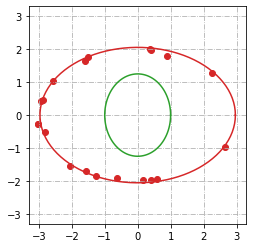

In [ ]:
# get the final results from the NN weights , and plot the resulted ellipse
plot_2Dpts(Y)
W_final = list(model.parameters())
print(W_final, W_final[0][0])
plot_Ellipse(W_final[0][0].detach().numpy() ,W_final[0][1].detach().numpy() , 'tab:red')
plot_Ellipse(Wx ,Wy , 'tab:green')

In [ ]:
# 3D ellipses - the conditional case 
###########################################################################################################################################################################

In [ ]:
# x = 1D numpy array of the x-coordinates of the ellipses
# xAxislen, yAxisLen 1D tesors of the y and Z axes lengths of the ellipses (one ellipse per x-value)
def plot_Ellipses3DGivenX(x, xAxisLen, yAxisLen, color_='tab:red', samples =100):
  ellipsesNo = x.shape[0]
  if(ellipsesNo ==0):
    x = np.arange(0.0,1.0, 0.01)
    ellipsesNo = x.shape[0]
    
  EllipseAxis = np.array([xAxisLen,yAxisLen])
  print(EllipseAxis)
  EllipseRotatedAxis = np.array([yAxisLen,xAxisLen])
  
  # the axes computation
  EllipsesAxes =(np.outer(EllipseAxis,x) + np.outer(EllipseRotatedAxis, 1-x))*np.exp(2*x)
  print('EllipsesAxes=', EllipsesAxes)

  
  print('x=',x)
  an = np.linspace(0., 2. * np.pi, samples)
  #print('an=',an)

  # 3D frame prepare
  fig = plt.figure()
  ax = plt.axes(projection = '3d')  

  for i in range(ellipsesNo) :
    X = np.ones(samples)*x[i]      
    ax.plot3D(X, EllipsesAxes[0][i] * np.cos(an), EllipsesAxes[1][i] * np.sin(an))
   

In [ ]:
def testPlot3DEllipse():
  samplesNo = 10
  x_ = torch.rand([samplesNo], requires_grad=False)
  x = x_.detach().numpy()
  print(x, x.shape)
  plot_Ellipses3DGivenX(x, 5.0, 2.0)
  # create crosssectiona with equal spacing
  r=np.array([])
  plot_Ellipses3DGivenX(r, 5.0, 2.0)

[0.90192896 0.932721   0.6868445  0.6756813  0.4683687  0.04441541
 0.11380047 0.7884369  0.3180678  0.24397749] (10,)
[5. 2.]
EllipsesAxes= [[28.57839163 30.99032673 16.03868091 15.55520281  8.68861486  2.33141574
   2.93982642 21.12723838  5.58098126  4.45026736]
 [13.93282835 14.22120205 11.61058342 11.48359362  9.17288541  5.31885448
   5.84926243 12.75137414  7.6431824   6.95260294]]
x= [0.90192896 0.932721   0.6868445  0.6756813  0.4683687  0.04441541
 0.11380047 0.7884369  0.3180678  0.24397749]
[5. 2.]
EllipsesAxes= [[ 2.          2.07100872  2.14407019  2.21923838  2.29656858  2.37611747
   2.45794314  2.5421051   2.62866435  2.71768341  2.80922634  2.90335878
   3.00014799  3.09966291  3.20197415  3.30715408  3.41527686  3.52641845
   3.64065671  3.75807139  3.87874421  4.00275889  4.1302012   4.26115902
   4.39572237  4.53398349  4.67603687  4.82197928  4.9719099   5.1259303
   5.28414452  5.44665916  5.6135834   5.78502908  5.96111075  6.14194576
   6.32765429  6.51835945  

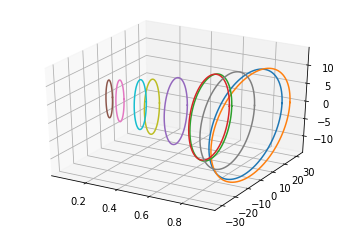

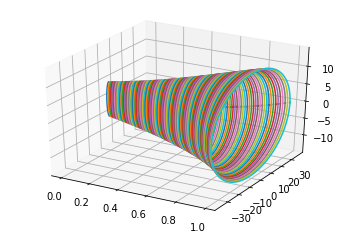

In [ ]:
testPlot3DEllipse()

In [ ]:
# prepare the sampled rotating ellipse points based on input axes length and noise
# output Y[3][N] = [Y[1,:], Y[2,:] , Y[3,:]] = [X, Yx, Yy]
def sampleNoisedRotatingEllipsePts(samplesNo, x0AxisLen , y0AxisLen, noiseStd = 0.05):
  EllipseAxis = torch.tensor([x0AxisLen,y0AxisLen])
  EllipseRotatedAxis = torch.tensor([y0AxisLen,x0AxisLen])
  # X ~ uniform distribution on[0,1]
  X = torch.rand([samplesNo], requires_grad=False)
  #print('X=', X)
  # the axes computation
  axes = (torch.outer(EllipseAxis,X) + torch.outer(EllipseRotatedAxis, 1-X))*torch.exp(2*X)
  #print('axes=',axes)
 
  #uniform distribution on[0,2*pi] for the theta
  theta =torch.rand([samplesNo])*2*math.pi
  #print("theta=" ,theta,'\n')


  #normal distribution for the noise 
  noise = torch.empty([samplesNo])
  noise.normal_(mean =0 ,std = noiseStd)
  #print("noise=",noise,'\n')
  #create the 'noised' ellipse points data 
  Y1 = torch.cat((X, torch.cos(theta)*axes[0,:]+noise, torch.sin(theta)*axes[1,:]+noise ), 0)
 
  ptsDim = (3,int(Y1.size(0)/3))
  ellipsePts = torch.reshape(Y1,ptsDim)
  #print ("ellipse pts =", ellipsePts,'  shape = ' ,ellipsePts.shape,'\n')

  return ellipsePts

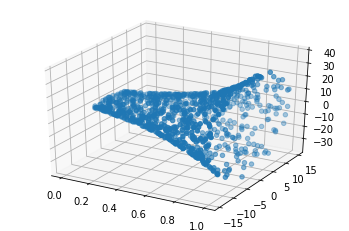

In [ ]:
#tetsing the 3D points data creation
ellipsePts = sampleNoisedRotatingEllipsePts(1000, 2.0 , 5.0)
fig = plt.figure()
ax = plt.axes(projection = '3d')  
ax.scatter(ellipsePts[0,:] , ellipsePts[1,:] , ellipsePts[2,:] )

In [ ]:
# The energy function 

#  W , Yi = tensor[batchsize][2] 
# err = tensor[batchsize]    

def F_inf3D(W,Yi): 
  Z = predicted_latent() # [latentSize][2]
  
  #print('W=',W)

  # define W_stretched =tensor[batchsize][latentSize][2]  ;  W_stretched[i][j][:] := W[i][:] for all j=1,.. ,latentSize
  Wj = W.unsqueeze(1)  
  W_stretched = Wj.expand(-1, latentSize, -1 )
  # define Z_stretched= tensor[batchsize][latentSize][2] ;  Z_stretched[i][j][:] := Z[j][:] for all i=1..batchsize
  Zi= Z.unsqueeze(0)
  Z_stretched = Zi.expand(Yi.size(0),-1,-1)

   # Y_pred = tensor[batchsize][latentSize][2]  with  Y_pred[i][j][:] := [ W[i][0]*cos(theta(j)) , W[i][1]*sin(theta(j)) ] = [ W[i][0]*Z[j][0] , W[i][1]*Z[j][0] ]
  Y_pred = W_stretched*Z_stretched
  #print('Y_pred=',Y_pred.shape)
  # define Y_stretched =tensor[batchsize][latentSize][2]  ;  Y_stretched[i][j][:] := Y[i][:] for all j=1,.. ,latentSize
  Yj = Yi.unsqueeze(1)  
  Y_stretched = Yj.expand(-1, latentSize, -1 )
  #print('Y_stretched=', Y_stretched.shape)

  E = Y_stretched-Y_pred  #tensor[batchsize][latentSize][2]   with  E[i][j][:] = [Y[i][0] - W[i][0]*Z[j][0] ,Y[i][1] - W[i][1]*Z[j][0] ]
  #print('E',E)       
  E1= E.mul(E)         #tensor[batchsize][latentSize][2]           
  #print('E1',E1) 
  E2 = torch.sum(E1, dim=2)  #tensor[batchsize][latentSize]   with    E2[i][j] =  || [Y[i][0] - W[i][0]*Z[j][0] ,Y[i][1] - W[i][1]*Z[j][0] ] ||^2  , i =1.. batchSize ,  j=1..latentSize
  #print('E2=',E2.shape) 
  E3 = torch.min(E2, dim=1).values  #tensor[batchsize]    E3[i] = Min(j){ E2[i][j]}
  #print('E3=',E3.size(),E3.shape)
  err = torch.sum(E3) # sum the error on all batch points
  return err ,E3


In [ ]:
# the weights are the ellipse axes lengths W=(w1,w2) = NN output
# the NN is for the conditional case where x is given , namely given the x coordinate of the 3D point , the 
# NN outputs the lengths of the ellipse axes for x-cross section 
# for the input batch x =[[x1],..[xN]] , the model output is W = tensor[N][2] = [[wx_0,wy_0],[wx_1,wy_1],..  ,[wx_N,wy_N]]
class EllipseAxes3D(nn.Module):
  def __init__(self):
    super().__init__()  
    self.fc1 = nn.Linear(1,8)
    self.fc2 = nn.Linear(8,8)
    self.fc3 = nn.Linear(8,2)
  
  def forward(self,x):# x= [[x1],..[xN]] = [N][1] tensor all the x-axis of the surface noised 3D points of the batch
    x=self.fc1(x)
    x=F.relu(x)
    x=self.fc2(x)
    x=F.relu(x)
    x=self.fc3(x)
    return x 


In [ ]:
#from numpy.ma.core import shape
# define the 3D model
model3D = EllipseAxes3D()
optimizer3D = torch.optim.SGD(model3D.parameters(), lr = 0.001, momentum =0.5)
#optimizer3D = torch.optim.Adam(model3D.parameters(), lr = 0.001, weight_decay=1e-5)
print(list(model3D.parameters()))
print(model3D)



[Parameter containing:
tensor([[-0.2110],
        [-0.8062],
        [-0.6129],
        [-0.0545],
        [-0.5627],
        [ 0.1133],
        [-0.0511],
        [-0.2378]], requires_grad=True), Parameter containing:
tensor([-0.3233,  0.8204,  0.6368, -0.1896,  0.5320,  0.4413, -0.6883, -0.9223],
       requires_grad=True), Parameter containing:
tensor([[ 0.3099,  0.0619,  0.0101,  0.0729, -0.0870,  0.0839, -0.2806,  0.0011],
        [-0.1390,  0.0685, -0.1455, -0.0901,  0.2682,  0.1065,  0.1458,  0.3393],
        [-0.1815, -0.2210, -0.2893, -0.2161,  0.0797,  0.2667, -0.0770,  0.3321],
        [-0.0274,  0.3428,  0.1664, -0.0886,  0.0315, -0.1881,  0.1719,  0.0313],
        [-0.3405,  0.3168,  0.0979, -0.2140,  0.1825,  0.2031, -0.1479,  0.3422],
        [-0.3208,  0.0419,  0.3414, -0.2830,  0.2246, -0.2234, -0.2698,  0.1154],
        [-0.3531,  0.0892, -0.3303,  0.1942, -0.0973,  0.0963, -0.0967,  0.2499],
        [ 0.1958, -0.0688, -0.3379,  0.1405,  0.2702,  0.0565, -0.1039, -0.2

In [ ]:
#define the data
EllipsePtsNo = 2000
ellipsePts3D = sampleNoisedRotatingEllipsePts(EllipsePtsNo, 2.0 , 5.0, 0.001)
X = ellipsePts3D[0,:] # tensor[EllipsePtsNo]
Yt = torch.cat((ellipsePts3D[1,:], ellipsePts3D[2,:]) , 0) #tensor[EllipsePtsNo][2]=4[[y0_x, y0_y],[y1_x, y1_y],..]
ptsDim = (2,int(Yt.size(0)/2))
Yt = torch.reshape(Yt,ptsDim)
Yt = torch.transpose(Yt,0,1)
#print('X=' ,X,'\n Yt=' ,Yt ,'\n shape=', Yt.shape)

In [ ]:
#training : conditional case (3D ellipses)
from torch.autograd.grad_mode import no_grad

secondDiag =torch.tensor([[0.0, 1.0],[1.0, 0.0]],requires_grad=False) #to flip [x,y] to [y,x] with autograd
DataIterN0 = 1 # the number of times we iterate on the full data set
FullDataSetSize = Yt.size(0)
batchRatio = 100
batchSize = 20  # assuming FullDataSetSize =  batchRatio*batchSize

for iter in range(DataIterN0):
  for i in range (batchRatio):
    
    xi =X[batchSize*i: batchSize*(i+1)]
    xi= xi.view(xi.size(0),1) # tensor[batchSize] --> tensor[batchSize][1]
    Yi =Yt[batchSize*i: batchSize*(i+1),:] # tensor[batchSize][2]

    print('\n', i+1,':')
    #print('X=',xi, xi.shape,'\nYi=',Yi, Yi.shape)
    W=model3D(xi) # W =  tensor[batchSize][2]  with gradients!
  
    # Note , xi*W = [batchsize][2] = [[Wx_0*x0, Wy_0*x0], .. [Wx_N*xN, Wy_N*xN]]
    W_xi = (xi*W + (1-xi)*torch.matmul(W,secondDiag))*torch.exp(2*xi) # the resulted ellipse crossection for the given x; W_xi=tensor[batchsize][2]
    
    if i==0: #debug print for sanity - the error value for the nominal axis length, namely [Wx,Wy] that were used to create the data
      print('xi=', xi, '\nYi=', Yi, '\nWxi=', W_xi)
      with torch.no_grad():
        W_final = torch.zeros(batchSize,2)
        W_final[:,0]=-2.
        W_final[:,1]=-5.
        W_F = (xi*W_final + (1-xi)*torch.matmul(W_final,secondDiag))*torch.exp(2*xi)
        err_ideal,E3 =  F_inf3D(W_F,Yi)
        print('\nE3=' , E3)
        print('\nerr_ideal=' , err_ideal)
    err,E3 =  F_inf3D(W_xi,Yi)          
    print('ellipse axes = W =' ,W[0].data[:] , 'err = ' , err.item())
     
    optimizer3D.zero_grad()
    #print('err=', err)
    err.backward()
    #print('weights [d/dWx , d/dWy] gradients', W.grad)
    #weightslist = list(model.parameters())
    #print(weightslist)
    #print (weightslist[0].grad)
    optimizer3D.step()
    weightslist1 = list(model3D.parameters())
    # print('NN weights =', weightslist1)


 1 :
xi= tensor([[0.5032],
        [0.4958],
        [0.0553],
        [0.0605],
        [0.9562],
        [0.4302],
        [0.1657],
        [0.2929],
        [0.0832],
        [0.4862],
        [0.9494],
        [0.3625],
        [0.4224],
        [0.2532],
        [0.4175],
        [0.2576],
        [0.6611],
        [0.0774],
        [0.1992],
        [0.7770]]) 
Yi= tensor([[  9.0258,   3.1415],
        [  1.2120,   9.3244],
        [  2.8203,   2.0638],
        [ -2.8514,   2.0964],
        [-13.8068,  -9.5710],
        [ -6.7719,  -4.9412],
        [  3.2622,  -2.9706],
        [  7.3171,   0.7948],
        [ -3.4168,  -2.1066],
        [  8.8223,   3.0652],
        [ 11.9686, -17.9181],
        [  2.0021,   6.1771],
        [  8.4470,   1.7786],
        [ -5.0839,  -3.1667],
        [  4.0688,  -6.6124],
        [ -4.8805,   3.3612],
        [ -8.2893, -10.1766],
        [  0.2979,   2.6028],
        [ -5.5124,  -2.0956],
        [-10.9329, -10.2405]]) 
Wxi= tensor([[-0.1282,

In [ ]:
# examples for auto grad functions 
#######################################################################################################################################################

In [ ]:
#  | wx , Wy |
#  | Wx,  Wy | 
W= torch.tensor([0.1,0.5],requires_grad=True)
Wj = W.unsqueeze(0)  
W_stretched = Wj.expand(2,-1 )
print(W_stretched)
coef= torch.tensor([[2.,1.],[4.,-1.]],requires_grad=False)
print(coef)
bias= torch.tensor([[-1.,-2.],[1.,-1.]],requires_grad=False)
print(bias)
E = coef*W_stretched+bias
E1=E.mul(E)
E2 = torch.sum(E1, dim = 1)
err = torch.sum(E2)
err.backward()
print(W.grad)

tensor([[0.1000, 0.5000],
        [0.1000, 0.5000]], grad_fn=<ExpandBackward0>)
tensor([[ 2.,  1.],
        [ 4., -1.]])
tensor([[-1., -2.],
        [ 1., -1.]])
tensor([8., 0.])


In [ ]:
W= torch.tensor([0.1,0.5],requires_grad=True)
Wj = W.unsqueeze(0)  
W_stretched = Wj.expand(2,-1 )
print(W_stretched)
coef= torch.tensor([[2.,1.],[4.,-1.]],requires_grad=False)
print(coef)
bias= torch.tensor([[-1.,-2.],[1.,-1.]],requires_grad=False)
print(bias)
E = coef*W_stretched+bias
E1=E.mul(E)
E2 = torch.min(E1, dim = 0).values
err = torch.sum(E2)
err.backward()
print(W.grad)

tensor([[0.1000, 0.5000],
        [0.1000, 0.5000]], grad_fn=<ExpandBackward0>)
tensor([[ 2.,  1.],
        [ 4., -1.]])
tensor([[-1., -2.],
        [ 1., -1.]])
tensor([-3.2000, -3.0000])
